<a href="https://colab.research.google.com/github/marendtz/ModelNER/blob/master/XLMR_finetune_pan_and_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [1]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom')
except:
  print("no such folder")

In [2]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [3]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Jun 15 13:53 ./
drwxr-xr-x 1 root root 4096 Jun 15 12:15 ../
drwxr-xr-x 4 root root 4096 Jun 13 17:31 .config/


'/content'

In [4]:
# clone github repo
!git clone https://{token}@github.com/marendtz/ModelNER.git

Cloning into 'ModelNER'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 69 (delta 37), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (69/69), 1.04 MiB | 4.32 MiB/s, done.


In [5]:
# check python version
!python --version

Python 3.10.12


In [6]:
# install dependencies
%pip install -r /content/ModelNER/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Get and Analyze dataset from Huggingface**

In [8]:
# login to HugginFace to enable upload of model
notebook_login()

In [20]:
# define model

# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...

ds = load_dataset("maren-hugg/sustainability_ner")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


**Prepare input data for following training of the model XLMRobertaForTokenClassification (with our config=labels, device, ...)**

In [10]:
# prepare dataset
ds_custom = ds
print("Example element in Custom Dataset:")
ds_custom_element = ds["train"][1]
for key, value in ds_custom_element.items():
    print(f"{key}: {value}")

Example element in Custom Dataset:
ner_tags: [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]
tokens: ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']


In [11]:
# show info about tag feature --> we already defined the varibale tags earlier
# --> DatasetDict holds information about all features used (like infos on columns in dataframe)
print('----------features----------------')
print(ds_custom["train"].features)
print('----------feature ner_tags----------------')
print(ds_custom["train"].features["ner_tags"].feature)


----------features----------------
{'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
----------feature ner_tags----------------
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [12]:
# examples
print(ds_custom["train"][1])
print(ds_custom["train"][1]["tokens"])
print(ds_custom["train"][1]["ner_tags"])

{'ner_tags': [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0], 'tokens': ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']}
['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']
[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]


Count PER-Tag: 18
Count ORG-Tag: 474
Count LOC-Tag: 169
Count Tags: 661


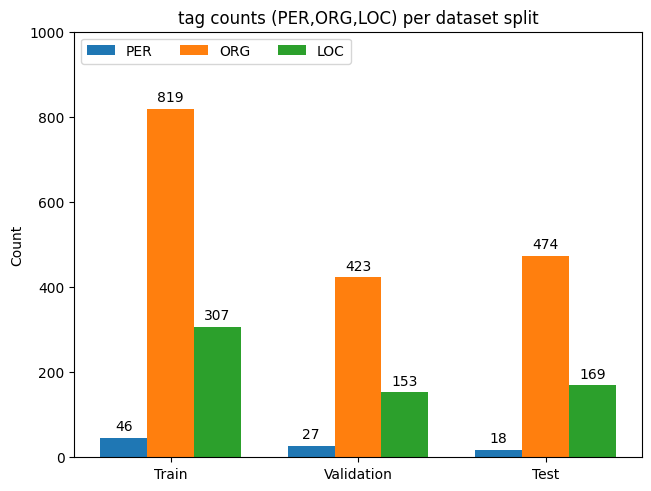

In [13]:
# getting info about tag-counts of labeled data
count_per = 0
count_org = 0
count_loc = 0
for sentence in ds_custom["train"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
train_count_per= count_per
train_count_org= count_org
train_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["validation"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
val_count_per= count_per
val_count_org= count_org
val_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["test"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
test_count_per= count_per
test_count_org= count_org
test_count_loc= count_loc


print(f"Count PER-Tag: {count_per}")
print(f"Count ORG-Tag: {count_org}")
print(f"Count LOC-Tag: {count_loc}")
print(f"Count Tags: {count_per + count_org + count_loc}")

splits = ("Train", "Validation", "Test")
split_values = {
    'PER': (train_count_per, val_count_per, test_count_per),
    'ORG': (train_count_org, val_count_org, test_count_org),
    'LOC': (train_count_loc, val_count_loc, test_count_loc),
}

x = np.arange(len(splits))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in split_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('tag counts (PER,ORG,LOC) per dataset split')
ax.set_xticks(x + width, splits)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1000)

plt.show()

**Set tokenizer**

In [14]:
# setup for tokenization
xlmr_model_name = "maren-hugg/xlm-roberta-base-finetuned-panx-en"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [15]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_ds_custom_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['ner_tags', 'tokens'])



In [16]:
# encode dataset
ds_custom_encoded = encode_ds_custom_dataset(ds_custom)
print("Encoded example:")
print(ds_custom_encoded["train"][1])

Encoded example:
{'input_ids': [0, 81201, 24639, 83, 2843, 10, 32786, 111, 70, 143889, 7, 242, 125413, 1832, 297, 25617, 185790, 136, 83, 127298, 2831, 111, 70, 2265, 165410, 36457, 538, 41361, 71, 17721, 70, 12924, 136, 39108, 289, 53099, 136, 70, 79883, 94492, 52350, 69941, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 4, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 3, -100, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, 4, 0, 0, 0, -100, -100]}


**Define performance measures**

In [17]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists


# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": f1_score(y_true, y_pred)
          #"classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2) # throws error within parameter optimization
          }


**Finetuning XLM-RoBERTa and Upload to Huggingface**

In [21]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [22]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
num_epochs = 3
batch_size = 16
logging_steps = len(ds_custom_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-custom"
training_args = TrainingArguments(output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps", eval_steps=batch_size, # Number of update steps between two evaluations if evaluation_strategy="steps".
                                  save_strategy="steps", save_steps=1e6,
                                  learning_rate=5e-5, #  The initial learning rate for AdamW optimizer.
                                  weight_decay=0.01, # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
                                  disable_tqdm=False,
                                  logging_strategy="steps", logging_steps=batch_size,  # Number of update steps between two logs if logging_strategy="steps".
                                  push_to_hub=True)

In [23]:
# this model needs to be created at huggingface:
f"{xlmr_model_name}-custom"

'maren-hugg/xlm-roberta-base-finetuned-panx-en-custom'

In [24]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [25]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [26]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_custom_encoded["train"],
                  eval_dataset=ds_custom_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.1k/1.03G [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 24.0k/16.3M [00:00<?, ?B/s]

Download file runs/Jun12_07-30-12_32324690376c/events.out.tfevents.1686555032.32324690376c.8733.4: 100%|######…

Download file runs/Jun12_07-39-17_32324690376c/events.out.tfevents.1686555569.32324690376c.8733.6: 100%|######…

Download file runs/Jun12_07-33-18_32324690376c/events.out.tfevents.1686555213.32324690376c.8733.5: 100%|######…

Download file runs/Jun12_07-12-25_32324690376c/events.out.tfevents.1686553981.32324690376c.8733.1: 100%|######…

Download file runs/Jun12_07-44-54_32324690376c/events.out.tfevents.1686555907.32324690376c.8733.7: 100%|######…

Download file runs/Jun12_07-24-45_32324690376c/events.out.tfevents.1686554979.32324690376c.8733.3: 100%|######…

Clean file runs/Jun12_07-30-12_32324690376c/events.out.tfevents.1686555032.32324690376c.8733.4:  12%|#1       …

Clean file runs/Jun12_07-44-54_32324690376c/events.out.tfevents.1686555907.32324690376c.8733.7:  12%|#1       …

Clean file runs/Jun12_07-39-17_32324690376c/events.out.tfevents.1686555569.32324690376c.8733.6:   7%|7        …

Clean file runs/Jun12_07-12-25_32324690376c/events.out.tfevents.1686553981.32324690376c.8733.1:  17%|#6       …

Clean file runs/Jun12_07-33-18_32324690376c/events.out.tfevents.1686555213.32324690376c.8733.5:   5%|5        …

Clean file runs/Jun12_07-24-45_32324690376c/events.out.tfevents.1686554979.32324690376c.8733.3:  17%|#6       …

Download file runs/Jun15_12-45-19_cd3a4fb4af4b/events.out.tfevents.1686835345.cd3a4fb4af4b.2499.0: 100%|######…

Clean file runs/Jun15_12-45-19_cd3a4fb4af4b/events.out.tfevents.1686835345.cd3a4fb4af4b.2499.0:  10%|#        …

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

In [27]:
!pip install pickle5==0.0.10
import pickle5 as pickle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# optimize hyperparameters
# default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    n_trials=10, # number of trials
    # Choose among many libraries:
    # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
    search_alg=HyperOptSearch(metric="objective", mode="max"),
    # Choose among schedulers:
    # https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
    scheduler=ASHAScheduler(metric="objective", mode="max")
)

2023-06-15 14:00:55,590	INFO worker.py:1636 -- Started a local Ray instance.
2023-06-15 14:00:59,745	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py:611: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/latest/tune/api/trainable.html

  warnings.warn(


== Status ==
Current time: 2023-06-15 14:00:59 (running for 00:00:00.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+--------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_bat |   seed |
|                     |          |       |                 |                    |                ch_size |        |
|---------------------+----------+-------+-----------------+--------------------+------------------------+--------|
| _objective_b2a8527c | PENDING  |       |     1.12872e-05 |                  1 |                     32 |   17.1 |
+---------------------+----------+-------+---------

(pid=33457) 2023-06-15 14:01:04.728987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:01:04 (running for 00:00:05.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+--------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_bat |   seed |
|                     |          |       |                 |                    |                ch_size |        |
|---------------------+----------+-------+-----------------+--------------------+------------------------+--------|
| _objective_b2a8527c | PENDING  |       |     1.12872e-05 |                  1 |                     32 |   17.1 |
+---------------------+----------+-------+-----

(_objective pid=33457) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=33457)   warnings.warn(
 94%|█████████▍| 15/16 [00:02<00:00,  7.88it/s]


(_objective pid=33457) {'loss': 0.1961, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33457) 
 38%|███▊      | 6/16 [00:00<00:00, 58.99it/s]
(_objective pid=33457) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.09it/s]


Result for _objective_b2a8527c:
  date: 2023-06-15_14-01-14
  done: false
  epoch: 1.0
  eval_accuracy: 0.7037344398340248
  eval_f1: 0.7037344398340248
  eval_loss: 0.16042077541351318
  eval_precision: 0.7043189368770764
  eval_recall: 0.703150912106136
  eval_runtime: 0.3963
  eval_samples_per_second: 630.877
  eval_steps_per_second: 40.376
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.8149387286512617
  pid: 33457
  time_since_restore: 8.920766592025757
  time_this_iter_s: 8.920766592025757
  time_total_s: 8.920766592025757
  timestamp: 1686837674
  training_iteration: 1
  trial_id: b2a8527c
  
(_objective pid=33457) {'eval_loss': 0.16042077541351318, 'eval_f1': 0.7037344398340248, 'eval_precision': 0.7043189368770764, 'eval_recall': 0.703150912106136, 'eval_accuracy': 0.7037344398340248, 'eval_runtime': 0.3963, 'eval_samples_per_second': 630.877, 'eval_steps_per_second': 40.376, 'epoch': 1.0}
(_objective pid=33457) {'train_runtime': 2

                                               
100%|██████████| 16/16 [00:02<00:00,  6.10it/s]


Trial _objective_b2a8527c completed.
== Status ==
Current time: 2023-06-15 14:01:15 (running for 00:00:15.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 2.8149387286512617
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 2/10 (1 PENDING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                   |                 |                    |                ch_size |         |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+---------+-

(pid=33635) 2023-06-15 14:01:20.616921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:01:25 (running for 00:00:25.38)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 2.8149387286512617
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _o

(_objective pid=33635) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=33635)   warnings.warn(
  0%|          | 0/126 [00:00<?, ?it/s]
(_objective pid=33635) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 12%|█▏        | 15/126 [00:00<00:06, 16.86it/s]


(_objective pid=33635) {'loss': 0.2007, 'learning_rate': 1.8018235929920592e-05, 'epoch': 0.25}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 57.82it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.53it/s]


Result for _objective_4c502313:
  date: 2023-06-15_14-01-29
  done: false
  epoch: 0.25
  eval_accuracy: 0.7978227060653189
  eval_f1: 0.7978227060653189
  eval_loss: 0.1628347784280777
  eval_precision: 0.7510980966325037
  eval_recall: 0.8507462686567164
  eval_runtime: 0.3977
  eval_samples_per_second: 628.565
  eval_steps_per_second: 40.228
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.1974897774198583
  pid: 33635
  time_since_restore: 7.700400114059448
  time_this_iter_s: 7.700400114059448
  time_total_s: 7.700400114059448
  timestamp: 1686837689
  training_iteration: 1
  trial_id: 4c502313
  
(_objective pid=33635) {'eval_loss': 0.1628347784280777, 'eval_f1': 0.7978227060653189, 'eval_precision': 0.7510980966325037, 'eval_recall': 0.8507462686567164, 'eval_accuracy': 0.7978227060653189, 'eval_runtime': 0.3977, 'eval_samples_per_second': 628.565, 'eval_steps_per_second': 40.228, 'epoch': 0.25}


                                                
 25%|██▍       | 31/126 [00:02<00:05, 16.20it/s]


== Status ==
Current time: 2023-06-15 14:01:30 (running for 00:00:30.38)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.101852015227709
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _ob

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 59.34it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.24it/s]


(_objective pid=33635) {'eval_loss': 0.11064042896032333, 'eval_f1': 0.8259109311740891, 'eval_precision': 0.8069620253164557, 'eval_recall': 0.845771144278607, 'eval_accuracy': 0.8259109311740891, 'eval_runtime': 0.3924, 'eval_samples_per_second': 637.1, 'eval_steps_per_second': 40.774, 'epoch': 0.51}


                                                
 38%|███▊      | 48/126 [00:03<00:04, 16.02it/s]


(_objective pid=33635) {'loss': 0.0922, 'learning_rate': 1.2776567295761876e-05, 'epoch': 0.76}


(_objective pid=33635) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 59.30it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.37it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 54.37it/s]
                                               


(_objective pid=33635) {'eval_loss': 0.10625919699668884, 'eval_f1': 0.8365695792880259, 'eval_precision': 0.8167456556082149, 'eval_recall': 0.857379767827529, 'eval_accuracy': 0.8365695792880259, 'eval_runtime': 0.3934, 'eval_samples_per_second': 635.519, 'eval_steps_per_second': 40.673, 'epoch': 0.76}


 50%|█████     | 63/126 [00:04<00:04, 15.52it/s]


(_objective pid=33635) {'loss': 0.0922, 'learning_rate': 1.0155732978682515e-05, 'epoch': 1.02}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 59.81it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.56it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 54.56it/s]
                                               


(_objective pid=33635) {'eval_loss': 0.11052927374839783, 'eval_f1': 0.8436246992782679, 'eval_precision': 0.8167701863354038, 'eval_recall': 0.8723051409618574, 'eval_accuracy': 0.8436246992782679, 'eval_runtime': 0.3908, 'eval_samples_per_second': 639.658, 'eval_steps_per_second': 40.938, 'epoch': 1.02}


 61%|██████    | 77/126 [00:06<00:03, 15.43it/s]


(_objective pid=33635) {'loss': 0.0797, 'learning_rate': 7.534898661603157e-06, 'epoch': 1.27}


 63%|██████▎   | 80/126 [00:06<00:02, 16.24it/s]
(_objective pid=33635) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 59.37it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.44it/s]


Result for _objective_4c502313:
  date: 2023-06-15_14-01-34
  done: false
  epoch: 1.27
  eval_accuracy: 0.8404170008019246
  eval_f1: 0.8404170008019246
  eval_loss: 0.10986099392175674
  eval_precision: 0.8136645962732919
  eval_recall: 0.8689883913764511
  eval_runtime: 0.3909
  eval_samples_per_second: 639.489
  eval_steps_per_second: 40.927
  hostname: cd3a4fb4af4b
  iterations_since_restore: 5
  node_ip: 172.28.0.12
  objective: 3.3634869892535924
  pid: 33635
  time_since_restore: 12.994823455810547
  time_this_iter_s: 1.3157663345336914
  time_total_s: 12.994823455810547
  timestamp: 1686837694
  training_iteration: 5
  trial_id: 4c502313
  
(_objective pid=33635) {'eval_loss': 0.10986099392175674, 'eval_f1': 0.8404170008019246, 'eval_precision': 0.8136645962732919, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8404170008019246, 'eval_runtime': 0.3909, 'eval_samples_per_second': 639.489, 'eval_steps_per_second': 40.927, 'epoch': 1.27}


                                                
100%|██████████| 16/16 [00:00<00:00, 54.44it/s]
                                               
 71%|███████   | 89/126 [00:07<00:02, 13.76it/s]


== Status ==
Current time: 2023-06-15 14:01:35 (running for 00:00:35.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.101852015227709
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------

 74%|███████▍  | 93/126 [00:07<00:02, 15.50it/s]


(_objective pid=33635) {'loss': 0.0625, 'learning_rate': 4.914064344523798e-06, 'epoch': 1.52}


 76%|███████▌  | 96/126 [00:07<00:01, 15.98it/s]
(_objective pid=33635) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 59.61it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.35it/s]


(_objective pid=33635) {'eval_loss': 0.10306738317012787, 'eval_f1': 0.8520325203252033, 'eval_precision': 0.835725677830941, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8520325203252033, 'eval_runtime': 0.3917, 'eval_samples_per_second': 638.235, 'eval_steps_per_second': 40.847, 'epoch': 1.52}


                                                
100%|██████████| 16/16 [00:00<00:00, 54.35it/s]
                                               
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=33635) {'loss': 0.0566, 'learning_rate': 2.293230027444439e-06, 'epoch': 1.78}


(_objective pid=33635) 
 38%|███▊      | 6/16 [00:00<00:00, 59.22it/s]
(_objective pid=33635) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.38it/s]


(_objective pid=33635) {'eval_loss': 0.11007467657327652, 'eval_f1': 0.8506860371267151, 'eval_precision': 0.8286163522012578, 'eval_recall': 0.8739635157545605, 'eval_accuracy': 0.8506860371267151, 'eval_runtime': 0.3929, 'eval_samples_per_second': 636.327, 'eval_steps_per_second': 40.725, 'epoch': 1.78}


                                                 
 99%|█████████▉| 125/126 [00:10<00:00, 15.44it/s]


(_objective pid=33635) {'train_runtime': 10.1771, 'train_samples_per_second': 98.26, 'train_steps_per_second': 12.381, 'train_loss': 0.09475917522869413, 'epoch': 2.0}
Result for _objective_4c502313:
  date: 2023-06-15_14-01-37
  done: true
  epoch: 1.78
  eval_accuracy: 0.8506860371267151
  eval_f1: 0.8506860371267151
  eval_loss: 0.11007467657327652
  eval_precision: 0.8286163522012578
  eval_recall: 0.8739635157545605
  eval_runtime: 0.3929
  eval_samples_per_second: 636.327
  eval_steps_per_second: 40.725
  experiment_tag: 2_learning_rate=0.0000,num_train_epochs=2,per_device_train_batch_size=8,seed=28.7535
  hostname: cd3a4fb4af4b
  iterations_since_restore: 7
  node_ip: 172.28.0.12
  objective: 3.4039519422092486
  pid: 33635
  time_since_restore: 15.61371922492981
  time_this_iter_s: 1.3016986846923828
  time_total_s: 15.61371922492981
  timestamp: 1686837697
  training_iteration: 7
  trial_id: 4c502313
  
Trial _objective_4c502313 completed.


100%|██████████| 126/126 [00:10<00:00, 12.38it/s]


== Status ==
Current time: 2023-06-15 14:01:40 (running for 00:00:40.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.101852015227709
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 3/10 (1 PENDING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _

(pid=33903) 2023-06-15 14:01:43.311188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:01:45 (running for 00:00:45.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.101852015227709
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 4/10 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------

(_objective pid=33903) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=33903)   warnings.warn(
 17%|█▋        | 16/96 [00:01<00:06, 13.21it/s]
(_objective pid=33903) 
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=33903) {'loss': 0.205, 'learning_rate': 8.869559487638799e-06, 'epoch': 0.5}


(_objective pid=33903) 
 38%|███▊      | 6/16 [00:00<00:00, 59.41it/s]
(_objective pid=33903) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.36it/s]


Result for _objective_c7575b7e:
  date: 2023-06-15_14-01-52
  done: true
  epoch: 0.5
  eval_accuracy: 0.7534357316087307
  eval_f1: 0.7534357316087307
  eval_loss: 0.15201325714588165
  eval_precision: 0.7350157728706624
  eval_recall: 0.7728026533996684
  eval_runtime: 0.3931
  eval_samples_per_second: 636.0
  eval_steps_per_second: 40.704
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.014689889487792
  pid: 33903
  time_since_restore: 7.999357461929321
  time_this_iter_s: 7.999357461929321
  time_total_s: 7.999357461929321
  timestamp: 1686837712
  training_iteration: 1
  trial_id: c7575b7e
  
Trial _objective_c7575b7e completed.
(_objective pid=33903) {'eval_loss': 0.15201325714588165, 'eval_f1': 0.7534357316087307, 'eval_precision': 0.7350157728706624, 'eval_recall': 0.7728026533996684, 'eval_accuracy': 0.7534357316087307, 'eval_runtime': 0.3931, 'eval_samples_per_second': 636.0, 'eval_steps_per_second': 40.704, 'epoch': 0.5}


                                               
 17%|█▋        | 16/96 [00:01<00:08,  9.19it/s]


== Status ==
Current time: 2023-06-15 14:01:55 (running for 00:00:55.65)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.106089833453825
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 4/10 (1 PENDING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _

(pid=34039) 2023-06-15 14:01:57.296784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:02:00 (running for 00:01:00.74)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.106089833453825
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 5/10 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------

(_objective pid=34039) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34039)   warnings.warn(
 17%|█▋        | 11/64 [00:00<00:04, 12.64it/s]


== Status ==
Current time: 2023-06-15 14:02:05 (running for 00:01:05.77)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.106089833453825
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 5/10 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34039) 
 38%|███▊      | 6/16 [00:00<00:00, 59.54it/s]


(_objective pid=34039) {'loss': 0.2156, 'learning_rate': 4.076509307381652e-06, 'epoch': 0.5}


(_objective pid=34039) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.30it/s]


Result for _objective_98443790:
  date: 2023-06-15_14-02-06
  done: true
  epoch: 0.5
  eval_accuracy: 0.6796610169491526
  eval_f1: 0.6796610169491526
  eval_loss: 0.1780874878168106
  eval_precision: 0.6949740034662045
  eval_recall: 0.6650082918739635
  eval_runtime: 0.3934
  eval_samples_per_second: 635.521
  eval_steps_per_second: 40.673
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.719304329238473
  pid: 34039
  time_since_restore: 8.031153440475464
  time_this_iter_s: 8.031153440475464
  time_total_s: 8.031153440475464
  timestamp: 1686837726
  training_iteration: 1
  trial_id: '98443790'
  
Trial _objective_98443790 completed.
(_objective pid=34039) {'eval_loss': 0.1780874878168106, 'eval_f1': 0.6796610169491526, 'eval_precision': 0.6949740034662045, 'eval_recall': 0.6650082918739635, 'eval_accuracy': 0.6796610169491526, 'eval_runtime': 0.3934, 'eval_samples_per_second': 635.521, 'eval_steps_per_second': 40.673, 'epoch': 0.5}


                                               
 25%|██▌       | 16/64 [00:01<00:05,  9.12it/s]


== Status ==
Current time: 2023-06-15 14:02:10 (running for 00:01:10.79)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.0603898614708087
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 5/10 (1 PENDING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| 

(pid=34173) 2023-06-15 14:02:11.288992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:02:15 (running for 00:01:15.82)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.0603898614708087
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 6/10 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+------

(_objective pid=34173) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34173)   warnings.warn(
 44%|████▍     | 14/32 [00:01<00:02,  6.84it/s]


== Status ==
Current time: 2023-06-15 14:02:20 (running for 00:01:20.86)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.0603898614708087
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 6/10 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+------

 50%|█████     | 16/32 [00:02<00:02,  6.87it/s]
(_objective pid=34173) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34173) 
 38%|███▊      | 6/16 [00:00<00:00, 59.41it/s]
(_objective pid=34173) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.29it/s]


Result for _objective_68b04668:
  date: 2023-06-15_14-02-21
  done: true
  epoch: 1.0
  eval_accuracy: 0.6501163692785105
  eval_f1: 0.6501163692785105
  eval_loss: 0.31253132224082947
  eval_precision: 0.6107871720116618
  eval_recall: 0.6948590381426202
  eval_runtime: 0.3935
  eval_samples_per_second: 635.325
  eval_steps_per_second: 40.661
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.605878948711303
  pid: 34173
  time_since_restore: 8.890460014343262
  time_this_iter_s: 8.890460014343262
  time_total_s: 8.890460014343262
  timestamp: 1686837741
  training_iteration: 1
  trial_id: 68b04668
  
Trial _objective_68b04668 completed.
(_objective pid=34173) {'eval_loss': 0.31253132224082947, 'eval_f1': 0.6501163692785105, 'eval_precision': 0.6107871720116618, 'eval_recall': 0.6948590381426202, 'eval_accuracy': 0.6501163692785105, 'eval_runtime': 0.3935, 'eval_samples_per_second': 635.325, 'eval_steps_per_second': 40.661, 'epoch': 1.0}


                                               
 50%|█████     | 16/32 [00:02<00:02,  6.14it/s]


== Status ==
Current time: 2023-06-15 14:02:25 (running for 00:01:25.92)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.014689889487792
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 6/10 (1 PENDING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
| _

(pid=34321) 2023-06-15 14:02:26.270830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:02:30 (running for 00:01:31.01)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.014689889487792
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 7/10 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------

(_objective pid=34321) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34321)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=34321) {'loss': 0.152, 'learning_rate': 1.8082987407407154e-05, 'epoch': 1.0}
== Status ==
Current time: 2023-06-15 14:02:35 (running for 00:01:36.04)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.014689889487792
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 7/10 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+--------

(_objective pid=34321) 
 38%|███▊      | 6/16 [00:00<00:00, 59.04it/s]
(_objective pid=34321) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.26it/s]


Result for _objective_7f092e42:
  date: 2023-06-15_14-02-36
  done: false
  epoch: 1.0
  eval_accuracy: 0.8248772504091653
  eval_f1: 0.8248772504091653
  eval_loss: 0.11171339452266693
  eval_precision: 0.81421647819063
  eval_recall: 0.835820895522388
  eval_runtime: 0.395
  eval_samples_per_second: 632.879
  eval_steps_per_second: 40.504
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2997918745313486
  pid: 34321
  time_since_restore: 8.865070343017578
  time_this_iter_s: 8.865070343017578
  time_total_s: 8.865070343017578
  timestamp: 1686837756
  training_iteration: 1
  trial_id: 7f092e42
  
(_objective pid=34321) {'eval_loss': 0.11171339452266693, 'eval_f1': 0.8248772504091653, 'eval_precision': 0.81421647819063, 'eval_recall': 0.835820895522388, 'eval_accuracy': 0.8248772504091653, 'eval_runtime': 0.395, 'eval_samples_per_second': 632.879, 'eval_steps_per_second': 40.504, 'epoch': 1.0}


                                               
100%|██████████| 16/16 [00:00<00:00, 54.26it/s]
                                               
 50%|█████     | 32/64 [00:04<00:03,  8.49it/s]


(_objective pid=34321) {'loss': 0.0727, 'learning_rate': 1.2055324938271437e-05, 'epoch': 2.0}


(_objective pid=34321) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34321) 
 38%|███▊      | 6/16 [00:00<00:00, 59.97it/s]
(_objective pid=34321) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.43it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 54.43it/s]
                                               


(_objective pid=34321) {'eval_loss': 0.10303311049938202, 'eval_f1': 0.8494271685761048, 'eval_precision': 0.8384491114701131, 'eval_recall': 0.8606965174129353, 'eval_accuracy': 0.8494271685761048, 'eval_runtime': 0.3908, 'eval_samples_per_second': 639.789, 'eval_steps_per_second': 40.946, 'epoch': 2.0}


  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=34321) {'loss': 0.0531, 'learning_rate': 6.027662469135718e-06, 'epoch': 3.0}


(_objective pid=34321) 
 38%|███▊      | 6/16 [00:00<00:00, 59.41it/s]
(_objective pid=34321) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.27it/s]


== Status ==
Current time: 2023-06-15 14:02:40 (running for 00:01:41.08)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.376324725853797 | Iter 1.000: 3.1517898054368416
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 7/10 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+------

                                               
100%|██████████| 16/16 [00:00<00:00, 54.27it/s]
                                               
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=34321) {'loss': 0.0449, 'learning_rate': 0.0, 'epoch': 4.0}


(_objective pid=34321) 
 38%|███▊      | 6/16 [00:00<00:00, 59.94it/s]
(_objective pid=34321) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.70it/s]


Result for _objective_7f092e42:
  date: 2023-06-15_14-02-43
  done: false
  epoch: 4.0
  eval_accuracy: 0.8576051779935274
  eval_f1: 0.8576051779935274
  eval_loss: 0.10330261290073395
  eval_precision: 0.8372827804107424
  eval_recall: 0.87893864013267
  eval_runtime: 0.3896
  eval_samples_per_second: 641.639
  eval_steps_per_second: 41.065
  hostname: cd3a4fb4af4b
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.431431776530467
  pid: 34321
  time_since_restore: 16.14171266555786
  time_this_iter_s: 2.4200592041015625
  time_total_s: 16.14171266555786
  timestamp: 1686837763
  training_iteration: 4
  trial_id: 7f092e42
  
(_objective pid=34321) {'eval_loss': 0.10330261290073395, 'eval_f1': 0.8576051779935274, 'eval_precision': 0.8372827804107424, 'eval_recall': 0.87893864013267, 'eval_accuracy': 0.8576051779935274, 'eval_runtime': 0.3896, 'eval_samples_per_second': 641.639, 'eval_steps_per_second': 41.065, 'epoch': 4.0}
(_objective pid=34321) {'train_runtime': 9.8

                                               
100%|██████████| 64/64 [00:09<00:00,  6.48it/s]


Trial _objective_7f092e42 completed.
== Status ==
Current time: 2023-06-15 14:02:45 (running for 00:01:46.17)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.1517898054368416
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 7/10 (1 PENDING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+---------------

(pid=34568) 2023-06-15 14:02:49.355466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:02:51 (running for 00:01:51.19)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.1517898054368416
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 8/10 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-----

(_objective pid=34568) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34568)   warnings.warn(
 13%|█▎        | 16/125 [00:00<00:05, 18.22it/s]


(_objective pid=34568) {'loss': 0.194, 'learning_rate': 1.0550391011299858e-05, 'epoch': 0.13}


(_objective pid=34568) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34568) 
 38%|███▊      | 6/16 [00:00<00:00, 59.53it/s]
(_objective pid=34568) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.21it/s]
                                                
 13%|█▎        | 16/125 [00:01<00:09, 11.48it/s]


Result for _objective_516ff796:
  date: 2023-06-15_14-02-57
  done: true
  epoch: 0.13
  eval_accuracy: 0.7131011608623548
  eval_f1: 0.7131011608623548
  eval_loss: 0.16858886182308197
  eval_precision: 0.7131011608623549
  eval_recall: 0.7131011608623549
  eval_runtime: 0.3923
  eval_samples_per_second: 637.191
  eval_steps_per_second: 40.78
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.852404643449419
  pid: 34568
  time_since_restore: 7.6241865158081055
  time_this_iter_s: 7.6241865158081055
  time_total_s: 7.6241865158081055
  timestamp: 1686837777
  training_iteration: 1
  trial_id: 516ff796
  
Trial _objective_516ff796 completed.
(_objective pid=34568) {'eval_loss': 0.16858886182308197, 'eval_f1': 0.7131011608623548, 'eval_precision': 0.7131011608623549, 'eval_recall': 0.7131011608623549, 'eval_accuracy': 0.7131011608623548, 'eval_runtime': 0.3923, 'eval_samples_per_second': 637.191, 'eval_steps_per_second': 40.78, 'epoch': 0.13}
==

(pid=34697) 2023-06-15 14:03:03.384917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:03:06 (running for 00:02:06.24)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.106089833453825
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 9/10 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+------

(_objective pid=34697) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34697)   warnings.warn(
  1%|          | 7/625 [00:00<00:39, 15.74it/s]


== Status ==
Current time: 2023-06-15 14:03:11 (running for 00:02:11.28)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.106089833453825
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 9/10 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+------

  2%|▏         | 13/625 [00:00<00:34, 17.80it/s]


(_objective pid=34697) {'loss': 0.2903, 'learning_rate': 3.839019020963766e-06, 'epoch': 0.13}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34697) 
 38%|███▊      | 6/16 [00:00<00:00, 58.76it/s]
(_objective pid=34697) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.96it/s]


Result for _objective_4e9b9a8a:
  date: 2023-06-15_14-03-12
  done: true
  epoch: 0.13
  eval_accuracy: 0.6678052946199831
  eval_f1: 0.6678052946199831
  eval_loss: 0.21553176641464233
  eval_precision: 0.6883802816901409
  eval_recall: 0.648424543946932
  eval_runtime: 0.3949
  eval_samples_per_second: 633.041
  eval_steps_per_second: 40.515
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.6724154148770394
  pid: 34697
  time_since_restore: 7.671960353851318
  time_this_iter_s: 7.671960353851318
  time_total_s: 7.671960353851318
  timestamp: 1686837792
  training_iteration: 1
  trial_id: 4e9b9a8a
  
Trial _objective_4e9b9a8a completed.
(_objective pid=34697) {'eval_loss': 0.21553176641464233, 'eval_f1': 0.6678052946199831, 'eval_precision': 0.6883802816901409, 'eval_recall': 0.648424543946932, 'eval_accuracy': 0.6678052946199831, 'eval_runtime': 0.3949, 'eval_samples_per_second': 633.041, 'eval_steps_per_second': 40.515, 'epoch': 0.13}


                                                
  3%|▎         | 16/625 [00:01<00:53, 11.41it/s]


== Status ==
Current time: 2023-06-15 14:03:16 (running for 00:02:16.33)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.0603898614708087
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 9/10 (1 PENDING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
|

(pid=34829) 2023-06-15 14:03:17.381142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:03:21 (running for 00:02:21.34)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.0603898614708087
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+----

(_objective pid=34829) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34829)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=34829) {'loss': 0.3363, 'learning_rate': 1.1303031250478987e-06, 'epoch': 0.5}
== Status ==
Current time: 2023-06-15 14:03:26 (running for 00:02:26.37)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.0603898614708087
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----

(_objective pid=34829) 
 38%|███▊      | 6/16 [00:00<00:00, 59.48it/s]
(_objective pid=34829) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.38it/s]
                                               
 17%|█▋        | 16/96 [00:01<00:08,  9.15it/s]


Result for _objective_c709d271:
  date: 2023-06-15_14-03-26
  done: true
  epoch: 0.5
  eval_accuracy: 0.6608969315499608
  eval_f1: 0.6608969315499608
  eval_loss: 0.2929011583328247
  eval_precision: 0.6287425149700598
  eval_recall: 0.6965174129353234
  eval_runtime: 0.3927
  eval_samples_per_second: 636.539
  eval_steps_per_second: 40.738
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.647053791005305
  pid: 34829
  time_since_restore: 8.031609773635864
  time_this_iter_s: 8.031609773635864
  time_total_s: 8.031609773635864
  timestamp: 1686837806
  training_iteration: 1
  trial_id: c709d271
  
Trial _objective_c709d271 completed.
(_objective pid=34829) {'eval_loss': 0.2929011583328247, 'eval_f1': 0.6608969315499608, 'eval_precision': 0.6287425149700598, 'eval_recall': 0.6965174129353234, 'eval_accuracy': 0.6608969315499608, 'eval_runtime': 0.3927, 'eval_samples_per_second': 636.539, 'eval_steps_per_second': 40.738, 'epoch': 0.5}
== Stat

(pid=34966) 2023-06-15 14:03:31.316456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-15 14:03:36 (running for 00:02:36.46)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 3.014689889487792
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-15_14-00-59
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------|
|

(_objective pid=34966) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34966)   warnings.warn(
  4%|▍         | 15/375 [00:00<00:19, 18.01it/s]


(_objective pid=34966) {'loss': 0.2273, 'learning_rate': 1.0758652514192775e-05, 'epoch': 0.13}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34966) 
 38%|███▊      | 6/16 [00:00<00:00, 59.13it/s]
(_objective pid=34966) 
 75%|███████▌  | 12/16 [00:00<00:00, 54.18it/s]
2023-06-15 14:03:39,973	INFO tune.py:1111 -- Total run time: 160.21 seconds (160.15 seconds for the tuning loop).


Result for _objective_7b2d0d36:
  date: 2023-06-15_14-03-39
  done: true
  epoch: 0.13
  eval_accuracy: 0.7260726072607261
  eval_f1: 0.7260726072607261
  eval_loss: 0.1541650891304016
  eval_precision: 0.722495894909688
  eval_recall: 0.7296849087893864
  eval_runtime: 0.3935
  eval_samples_per_second: 635.317
  eval_steps_per_second: 40.66
  hostname: cd3a4fb4af4b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 2.904326018220526
  pid: 34966
  time_since_restore: 7.70397686958313
  time_this_iter_s: 7.70397686958313
  time_total_s: 7.70397686958313
  timestamp: 1686837819
  training_iteration: 1
  trial_id: 7b2d0d36
  
Trial _objective_7b2d0d36 completed.
== Status ==
Current time: 2023-06-15 14:03:39 (running for 00:02:40.16)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4176550138612996 | Iter 1.000: 2.9870989216709756
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir:

In [33]:
# show best run
best_trial.hyperparameters

{'learning_rate': 2.4110649876542874e-05,
 'num_train_epochs': 4,
 'seed': 32.84673604817552,
 'per_device_train_batch_size': 32}

In [34]:
# load the best trial parameters into the trainer
for n, v in best_trial.hyperparameters.items():
  print(n,v)
  if n == "seed":
    v= round(v)
    print(v)
  setattr(trainer.args, n, v)

trainer.train()


learning_rate 2.4110649876542874e-05
num_train_epochs 4
seed 32.84673604817552
33
per_device_train_batch_size 32


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
16,0.166100,0.109848,0.828479,0.808847,0.849088,0.828479
32,0.071400,0.104811,0.843042,0.823065,0.864013,0.843042
48,0.052900,0.101434,0.845779,0.828299,0.864013,0.845779
64,0.041500,0.102212,0.852989,0.831496,0.875622,0.852989


TrainOutput(global_step=64, training_loss=0.08295893389731646, metrics={'train_runtime': 9.9395, 'train_samples_per_second': 201.218, 'train_steps_per_second': 6.439, 'total_flos': 89769700671816.0, 'train_loss': 0.08295893389731646, 'epoch': 4.0})

In [35]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837998.cd3a4fb4af4b.30403.1: 100%|#######…

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom
   12f7171..9a71b9b  main -> main

   12f7171..9a71b9b  main -> main



'https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom/commit/9a71b9b874018942fed82b27c14d071b4e91b4d7'

In [36]:
# info about trainer log history
metrics_train=trainer.state.log_history
for item in metrics_train:
  print(item)

{'loss': 0.1661, 'learning_rate': 1.8082987407407154e-05, 'epoch': 1.0, 'step': 16}
{'eval_loss': 0.1098480075597763, 'eval_f1': 0.8284789644012945, 'eval_precision': 0.8088467614533965, 'eval_recall': 0.8490878938640133, 'eval_accuracy': 0.8284789644012945, 'eval_runtime': 0.4108, 'eval_samples_per_second': 608.572, 'eval_steps_per_second': 38.949, 'epoch': 1.0, 'step': 16}
{'loss': 0.0714, 'learning_rate': 1.2055324938271437e-05, 'epoch': 2.0, 'step': 32}
{'eval_loss': 0.10481106489896774, 'eval_f1': 0.843042071197411, 'eval_precision': 0.8230647709320695, 'eval_recall': 0.8640132669983416, 'eval_accuracy': 0.843042071197411, 'eval_runtime': 0.4081, 'eval_samples_per_second': 612.621, 'eval_steps_per_second': 39.208, 'epoch': 2.0, 'step': 32}
{'loss': 0.0529, 'learning_rate': 6.027662469135718e-06, 'epoch': 3.0, 'step': 48}
{'eval_loss': 0.10143405199050903, 'eval_f1': 0.8457792207792206, 'eval_precision': 0.8282988871224165, 'eval_recall': 0.8640132669983416, 'eval_accuracy': 0.8457